# Introduction to scikit-learn

`scikit-learn` is a Machine Learning library for Python, in this tutorial we will learn about the `scikit-learn` interface walking through a regression problem, in details:

* load a dataset in `.csv` format with `pandas`
* preprocess the data to make them suitable for `scikit-learn`
* fit a Decision Tree to the data
* compare the predicted and true values
* plot the learning curve
* use cross validation to tune model parameters

First install `scikit-learn` with `conda` (recommended) or `pip`:

    conda install sklearn

or:

    pip install sklearn

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## The dataset: predict Abalone age

Abalone is a mollusc with a peculiar ear-shaped shell lined of mother of pearl.
Its age can be estimated counting the number of rings in their shell with a microscope, but it is a time consuming process, in this tutorial we will use Machine Learning to predict the age using physical measurements.

Picture of the shell of an Abalone:
![Abalone](http://upload.wikimedia.org/wikipedia/commons/0/0b/AbaloneInside.jpg)

The dataset is available from the [University of California Irvine Machine Learning data repository](http://archive.ics.uci.edu/ml/datasets/Abalone), we can download the [data in Comma-Separated Values format](http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data) in the current folder.

There are no column labels in the data, so we copy them from the documentation and use `pandas` to read and print few lines of the dataset.

In [3]:
column_names = ["sex", "length", "diameter", "height", "whole weight", 
                "shucked weight", "viscera weight", "shell weight", "rings"]
data = pd.read_csv("abalone.data", names=column_names)
print("Number of samples: %d" % len(data))
data.head()

Number of samples: 4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Sex is either *Male* ("M"), *Female* ("F") or *Infant* ("I"), this is not suitable for regression algorithms, so we create a binary/boolean feature for each of the 3 options:

In [4]:
# for more complicated cases use sklearn.feature_extraction.DictVectorizer
for label in "MFI":
    data[label] = data["sex"] == label
del data["sex"]

In [5]:
data.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,M,F,I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,True,False,False
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,True,False,False
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,False,True,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,True,False,False
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,False,True


Data in `sklearn` are structured as:

* a 2D `numpy` array (n_samples, n_features), where each column is a feature (e.g. sex and physical dimensions) for each sample, e.g. each measured Abalone.
* a 1D `numpy` array (n_samples) of the value we aim to predict, e.g. the number of rings, standard variable name `y`

In [6]:
y = data.rings.values

In [7]:
del data["rings"] # remove rings from data, so we can convert all the dataframe to a numpy 2D array.
X = data.values.astype(np.float)

## Split data in Training and Test sets

We can split the data into training and validation sets and use Machine Learning to create an estimator that can learn from  the training set and then check its performance on the test set.

In [9]:
from sklearn import cross_validation
train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y) # splits 75%/25% by default

## Fit a Decision Tree to the data

One of the simpler method is a Decision Tree, see this example:
![decision_tree_example.png](fig/decision_tree_example.png)
A Decision Tree learns from available data the best conditions to set on the features, e.g. the purpose and the programming language, to predict an output value, e.g. what format should be used.

The `DecisionTreeRegressor` is a similar algorithm used to estimate a continous variable instead of a discrete one:

In [10]:
from sklearn.tree import DecisionTreeRegressor
# create an estimator, optionally specifying parameters
model = DecisionTreeRegressor()
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and training data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)

We can visualize the results with a scatter-plot of the true number of rings against the predicted number of rings:

In [11]:
def scatter_y(true_y, predicted_y):
    """Scatter-plot the predicted vs true number of rings
    
    Plots:
       * predicted vs true number of rings
       * perfect agreement line
       * +2/-2 number dotted lines

    Returns the root mean square of the error
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(true_y, predicted_y, '.k')
    
    ax.plot([0, 30], [0, 30], '--k')
    ax.plot([0, 30], [2, 32], ':k')
    ax.plot([2, 32], [0, 30], ':k')
    
    rms = (true_y - predicted_y).std()
    
    ax.text(25, 3,
            "Root Mean Square Error = %.2g" % rms,
            ha='right', va='bottom')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    ax.set_xlabel('True number of rings')
    ax.set_ylabel('Predicted number of rings')
    
    return rms

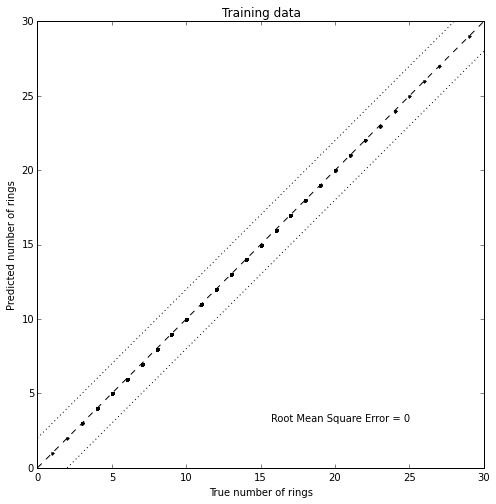

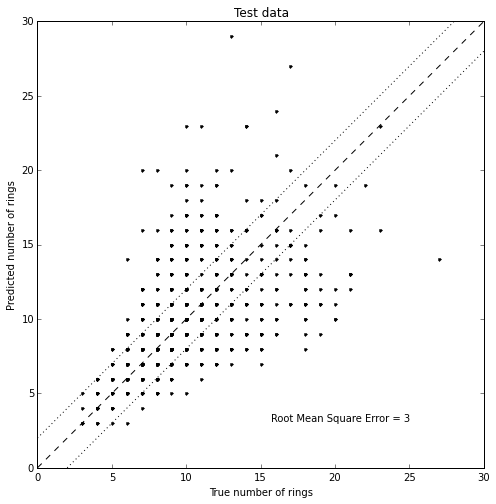

In [12]:
scatter_y(train_y, predicted_train_y)
plt.title("Training data")
scatter_y(test_y, predicted_test_y)
plt.title("Test data");

The Decision Tree overfits the training set, i.e. its parameters are fine tuned to reproduce the results of the training set but generalized badly to data not seen previously.

To prevent this issue we specify a maximum depth of the decision tree of $10$, so that the estimator does not "specialize" too much on the training data.

In [13]:
model = DecisionTreeRegressor(max_depth=10)
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and train data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)

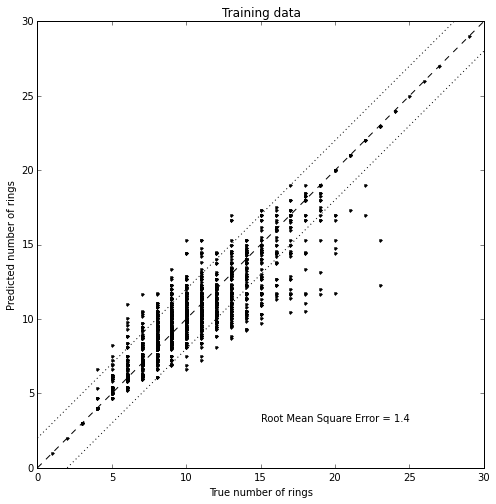

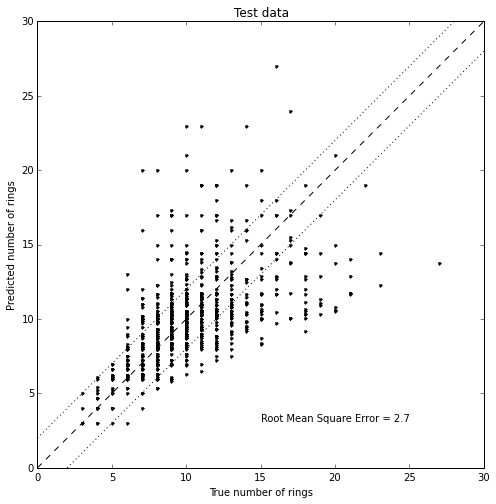

In [14]:
scatter_y(train_y, predicted_train_y)
plt.title("Training data")
rms_decision_tree = scatter_y(test_y, predicted_test_y)
plt.title("Test data");

## Plot learning curves

In [15]:
data_percentage_array = np.linspace(10, 100, 10)

In [16]:
train_error = []
test_error = []
for data_percentage in data_percentage_array:
    model = DecisionTreeRegressor(max_depth=10)
    number_of_samples = int(data_percentage / 100. * len(train_y))
    model.fit(train_X[:number_of_samples,:], train_y[:number_of_samples])

    predicted_train_y = model.predict(train_X)
    predicted_test_y = model.predict(test_X)

    train_error.append((predicted_train_y - train_y).std())
    test_error.append((predicted_test_y - test_y).std())

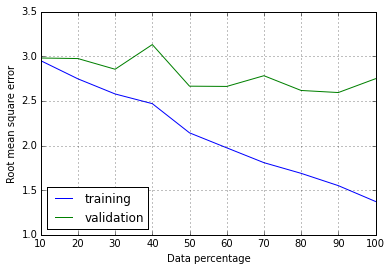

In [17]:
plt.plot(data_percentage_array, train_error, label='training')
plt.plot(data_percentage_array, test_error, label='validation')
plt.grid()
plt.legend(loc=3)
plt.xlabel('Data percentage')
plt.ylabel('Root mean square error');

Inspecting the learning curve, we see that the training error decreases as the `DecisionTree` fits better the data, but the validation error shows a significant gap compared to training error.
That typically means the model is not fitting the data well.

## Fit a Random Forest estimator to the data

In this case it is useful to test a more sophisticated model, for example Random Forests, i.e. a method that trains several Decision Trees and averages them.

`sklearn` has a very consistent interface, for any estimator, call `fit` for training then `predict` to estimate.

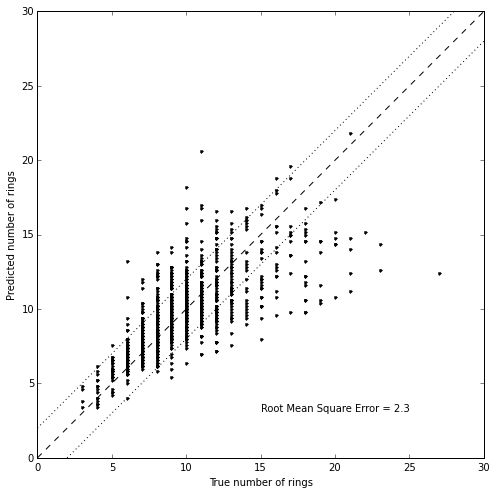

In [18]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=5)
model.fit(train_X, train_y)
predicted_test_y = model.predict(test_X)
rms_random_forest = scatter_y(test_y, predicted_test_y)

In [20]:
print("Root Mean Square error decreases from %.2g to %.2g." % (rms_decision_tree, rms_random_forest))

Root Mean Square error decreases from 2.7 to 2.3.


## Optimize model parameters

However we have not yet performed any optimization of the Random Forest parameters:

  * `max_depth`: the maximum depth of the Decision Trees
  * `max_features`: the max number of features to consider for each split

Given a list (or distributions) of parameters, `RandomizedSearchCV` performs a randomized search (less expensive than an exhaustive grid search) for the best parameters.

`RandomizedSearchCV` uses cross validation, i.e. randomly splits the input data in order to estimate the performance of each model more robustly.

In [21]:
model = RandomForestRegressor(n_estimators=100)

In [22]:
n_features = X.shape[1]

In [24]:
from sklearn.grid_search import RandomizedSearchCV
grid = RandomizedSearchCV(model, n_iter=20, 
            param_distributions=dict(
                                          max_depth=np.arange(5,20+1), 
                                          max_features=np.arange(1, n_features+1)
                                    )
         )
grid.fit(X, y)
print(grid.best_params_)

{'max_features': 5, 'max_depth': 8}


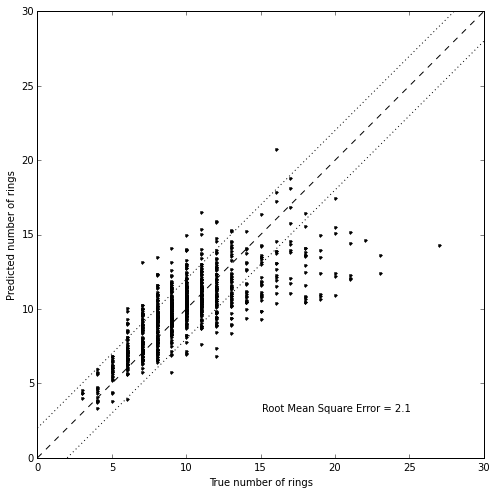

In [25]:
model = RandomForestRegressor(max_features=grid.best_params_["max_features"],
                              max_depth=grid.best_params_["max_depth"])
model.fit(train_X, train_y)
predicted_test_y = model.predict(test_X)
rms_optimized_random_forest = scatter_y(test_y, predicted_test_y)

In [26]:
print("Root Mean Square error decreases from %.2g to %.2g." % (rms_random_forest, rms_optimized_random_forest))

Root Mean Square error decreases from 2.3 to 2.1.


## Conclusion

In this tutorial we learnt about:

   * Prepare `y` vector of outputs and `X` matrix of features for `sklearn`
   * Split train and test sets: `cross_validation.train_test_split(X, y)`
   * Train an estimator: `model.fit(train_X, train_y)`
   * Use a trained estimator to predict unknown output values: `model.predict(test_X)`
   * Use `RandomizedSearchCV` to optimize model parameters